**To Do List**

1. Implementation of the equation 5 for the variable `weight_classes_dataset`
2. Evaluation methods (e.g., Quadratic Weighted Kappa (QWK))

In [1]:
# !pip install -U transformers

In [2]:
# !pip install gdown

In [3]:
import os
import random
import time
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel

# Set random seed for reproducibility
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  0


## Inputs




In [4]:
# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# number of classes in the dataset
n_class_dataset = 6

# name of each class in the dataset
label2class = {0: "human", 1: "chatGPT", 2: "cohere", 3: "davinci", 4: "bloomz", 5: "dolly"}

# batch size
batch_size = 1
assert batch_size == 1 # for GPT2

# Output dimension of G1 network
d_out = 768

# Dropout parameter
p_dropout = 0.5

# beta1 and beta2 for the ADAM optimizers
betas_ADAM = (0.9, 0.999) # Note: no values reported in the paper

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# lambda values in the loss functions
lambda_score = 1
lambda_feature_matching = 1

## Data




In [5]:
if not os.path.exists("/content/SubtaskB"):
    # https://github.com/mbzuai-nlp/SemEval2024-task8
    url = "https://drive.google.com/drive/folders/11YeloR2eTXcTzdwI04Z-M2QVvIeQAU6-"
    !gdown --folder $url

Retrieving folder list
Processing file 1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE subtaskB_dev.jsonl
Processing file 1k5LMwmYF7PF-BzYQNE2ULBae79nbM268 subtaskB_train.jsonl
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE
To: /content/SubtaskB/subtaskB_dev.jsonl
100% 4.93M/4.93M [00:00<00:00, 202MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268
To: /content/SubtaskB/subtaskB_train.jsonl
100% 155M/155M [00:00<00:00, 164MB/s]
Download completed


In [6]:
class SubtaskBDataset(Dataset):
    def __init__(self, file_path):
        self.data = []
        self.models = []
        self.sources = []
        with open(file_path, 'r') as file:
            for line in file:
                sample = json.loads(line)
                model = sample["model"]
                source = sample["source"]
                text = sample["text"]
                y_label = sample["label"]
                input_prompt = "Model: {0}".format(model)
                modified_text = f"<SOS> Model: {model} <BOT> Source: {source}, Text: {text} <EOS>"
                modified_sample = (modified_text, y_label, input_prompt)
                self.data.append(modified_sample)
                self.models.append(model)
                self.sources.append(source)
        self.models = np.unique(self.models)
        self.sources = np.unique(self.sources)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
          return self.data[idx]

In [7]:
datasetTrain = SubtaskBDataset("/content/SubtaskB/subtaskB_train.jsonl")
dataloaderTrain =  DataLoader(datasetTrain, batch_size=batch_size, shuffle=True)

print(datasetTrain.__len__())
print(datasetTrain.models)
print(datasetTrain.sources)
print(datasetTrain.__getitem__(0))

71027
['bloomz' 'chatGPT' 'cohere' 'davinci' 'dolly' 'human']
['arxiv' 'reddit' 'wikihow' 'wikipedia']
('<SOS> Model: chatGPT <BOT> Source: wikihow, Text: Forza Motorsport is a popular racing game that provides players with the ability to race on various tracks and in different vehicles. Whether you\'re a seasoned racer or a newbie, playing Forza Motorsport can be a fun experience. In this article, we will take you through the different steps on how to play Forza Motorsport.\n\nStep 1. Insert The Game Disc\n\nThe first step is to insert the game disc into your console or computer. Follow the instructions to set up the game.\n\nStep 2. Choose Your Game\n\nOnce the game is set up, choose the game you\'d like to play. Forza Motorsport has different modes: Career, Free Play, and Arcade. In this article, we will focus on the Arcade mode.\n\nStep 3. Just Make A Quick Race By The Arcade Mode\n\nOnce the Arcade mode is selected, choose "Quick Race" to get started quickly.\n\nStep 4. Pick A Rac

In [8]:
datasetVal = SubtaskBDataset("/content/SubtaskB/subtaskB_dev.jsonl")
dataloaderVal =  DataLoader(datasetVal, batch_size=batch_size, shuffle=False)

print(datasetVal.__len__())
print(datasetVal.models)
print(datasetVal.sources)
print(datasetVal.__getitem__(0))

3000
['bloomz' 'chatGPT' 'cohere' 'davinci' 'dolly' 'human']
['peerread']
('<SOS> Model: chatGPT <BOT> Source: peerread, Text: Overall, I found the paper "Machine Comprehension Using Match-LSTM and Answer Pointer" to be well-written and informative. The authors present a comprehensive approach for machine comprehension tasks utilizing Match-LSTM and answer pointer models. The experimental results reported in the paper demonstrate the effectiveness of the proposed approach, achieving state-of-the-art performance on several benchmark datasets.\n\nThe authors provide a clear explanation of the model architecture, with diagrams and equations to help illustrate the concepts. I appreciated the detailed description of each component of the model and the rationale behind their design choices. The use of attention mechanisms to weigh the significance of each word is a particularly elegant solution, and the authors do an excellent job of explaining how it works and its benefits compared to alter

# The fine-tuned models/tokenizers

In [9]:
def loadGPT2(freeze=True, fine_tuned_model_path="alinourian/GPT2-SemEval2023"):
    # Load the fine-tuned model and tokenizer
    modelGPT2 = GPT2LMHeadModel.from_pretrained(fine_tuned_model_path)
    tokenizerGPT2 = GPT2Tokenizer.from_pretrained(fine_tuned_model_path)
    if freeze:
        for param in modelGPT2.parameters():
            param.requires_grad = False
    return tokenizerGPT2, modelGPT2

In [10]:
def loadBERT(freeze, fine_tuned_model_path="mohammadhossein/SemEvalTask8_SubTaskB"):
    # Load the fine-tuned model and tokenizer
    modelBERT = BertForSequenceClassification.from_pretrained(fine_tuned_model_path)
    tokenizerBERT = AutoTokenizer.from_pretrained(fine_tuned_model_path)
    if freeze:
        for param in modelBERT.parameters():
            param.requires_grad = False
    return tokenizerBERT, modelBERT

In [11]:
def blockGPT2(input_text, tokenizerGPT2, modelGPT2):
    # input_text = "Model: chatGPT"
    input_ids = tokenizerGPT2.encode(input_text[0], return_tensors="pt").to(device)
    attention_mask = torch.ones_like(input_ids)
    # https://stackoverflow.com/questions/69609401/suppress-huggingface-logging-warning-setting-pad-token-id-to-eos-token-id
    output = modelGPT2.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=400,
        num_beams=1,
        temperature=0.8,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizerGPT2.eos_token_id
    )
    generated_text = tokenizerGPT2.decode(output[0], skip_special_tokens=True)

    return generated_text

In [12]:
def blockBERT(input_text, tokenizerBERT, modelBERT):
    # https://discuss.huggingface.co/t/how-to-get-cls-embeddings-from-bertfortokenclassification-model/9276/2
    inputs = tokenizerBERT(input_text, return_tensors="pt", truncation=True).to(device)
    outputs = modelBERT(**inputs, output_hidden_states=True)
    last_hidden_states = outputs.hidden_states[-1]
    CLS_hidden_states = last_hidden_states[:, 0, :] # (bs, 768)
    return CLS_hidden_states

## Generator




In [13]:
# # Generator G1, see figure 2a
# class GeneratorG1(nn.Module):
#     def __init__(self):
#         super(GeneratorG1, self).__init__()
#         self.main = nn.Sequential(
#             # input: Z
#             nn.Linear(d_in, d_out),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=p_dropout),
#             nn.Linear(d_out, d_out)
#             # output: v_G
#         )

#     def forward(self, input):
#         return self.main(input)

In [14]:
# Generator G3, see figure 2c
class GeneratorG3(nn.Module):
    def __init__(self):
        super(GeneratorG3, self).__init__()
        tokenizerGPT2, modelGPT2 = loadGPT2(freeze=True)
        tokenizerBERT, modelBERT = loadBERT(freeze=False)
        self.tokenizerGPT2 = tokenizerGPT2
        self.tokenizerBERT = tokenizerBERT
        self.modelGPT2 = modelGPT2
        self.modelBERT = modelBERT

    def forward(self, input_prompt):
        generated_text = blockGPT2(input_prompt, self.tokenizerGPT2, self.modelGPT2)
        v_G = blockBERT(generated_text, self.tokenizerBERT, self.modelBERT)
        return v_G

In [15]:
# Create the generator
netG = GeneratorG3().to(device)

# Print the model
print(netG)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

GeneratorG3(
  (modelGPT2): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50261, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50261, bias=False)
  )
  (modelBERT): BertForSequenceCl

## Discriminator




In [16]:
# Discriminator D, see figure 2d
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq1 = nn.Sequential(
            # input: v_G or v_B
            nn.Dropout(p=p_dropout),
            nn.Linear(d_out, d_out))
        self.seq2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Dropout(p=p_dropout),
            nn.Linear(d_out, 1 + n_class_dataset), # +1 for the probability of this sample being fake/real.
            # output: logits, format: [fake score, dataset classes]
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        features = self.seq1(input) # required for the feature matching loss
        logits = self.seq2(features)
        probs = self.softmax(logits)
        return features, logits, probs

In [17]:
# Create the Discriminator
netD = Discriminator().to(device)

# Print the model
print(netD)

Discriminator(
  (seq1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=768, out_features=768, bias=True)
  )
  (seq2): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=768, out_features=7, bias=True)
  )
  (softmax): Softmax(dim=-1)
)


## BERT (red block)

In [18]:
# BERT block for processing the real dataset, pictured in red in figure 1
tokenizerBERT_red, modelBERT_red = loadBERT(freeze=True)
modelBERT_red.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Training




In [19]:
criterionGAN = nn.BCEWithLogitsLoss()
criterionScore = nn.CrossEntropyLoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=betas_ADAM)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=betas_ADAM)

# Establish convention for real and fake labels during training
real_label = 0.
fake_label = 1.

In [20]:
# Training Loop

# Lists to keep track of progress
D_losses = []
G_losses = []
iters = 0

time_start = time.time()
print("Starting Training Loop ...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloaderTrain, 0):

        # data is a list of [text, y_label, input_prompt]
        text = data[0] # text samples
        y_label = data[1].to(device) # true class labels
        input_prompt = data[2] # used for GPT2
        # output of the BERT module for real samples (CLS hidden state)
        v_B = blockBERT(text, tokenizerBERT_red, modelBERT_red)

        ############################
        # (1) Update D network
        ############################
        ## Train with all-real batch
        netD.zero_grad()

        labelGAN = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        _, logits_real, _ = netD(v_B)
        loss_D_real = criterionGAN(logits_real[:, 0], labelGAN)
        loss_D_score = criterionScore(logits_real[:, 1:], y_label)
        loss_D_real_and_score = loss_D_real + lambda_score*loss_D_score
        loss_D_real_and_score.backward() # Calculate gradients for D

        ## Train with all-fake batch
        v_G = netG(input_prompt)
        labelGAN.fill_(fake_label)
        _, logits_fake, _ = netD(v_G.detach())
        loss_D_fake = criterionGAN(logits_fake[:, 0], labelGAN)
        loss_D_fake.backward() # Calculate gradients for D

        loss_D_total = loss_D_real + loss_D_fake + lambda_score*loss_D_score
        optimizerD.step() # Update D

        ############################
        # (2) Update G network
        ############################
        netG.zero_grad()

        labelGAN.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass
        features_real, _, _ = netD(v_B)
        features_fake, logits_fake, _ = netD(v_G)
        loss_G_caught = criterionGAN(logits_fake[:, 0], labelGAN)
        loss_G_feature_matching = torch.mean(torch.square(torch.mean(features_real, dim=0) - torch.mean(features_fake, dim=0)))

        loss_G_total = loss_G_caught + lambda_feature_matching*loss_G_feature_matching
        loss_G_total.backward() # Calculate gradients for G
        optimizerG.step() # Update G

        ############################
        # Training statistics
        ############################
        if i % 10 == 0:
            elapsed_time = time.time() - time_start
            print('[%3d/%3d][%3d/%3d]\tLoss_D: %.4f\tLoss_G: %.4f\tElapsedTime: %.1f'
                  % (epoch, num_epochs, i, len(dataloaderTrain), loss_D_total.item(), loss_G_total.item(), elapsed_time))

        # Save Losses for plotting later
        D_losses.append(loss_D_total.item())
        G_losses.append(loss_G_total.item())

        iters += 1
print("--------------------------------------------------------------------------------------------")

Starting Training Loop ...
[  0/ 10][  0/71027]	Loss_D: 3.3881	Loss_G: 1.1854	ElapsedTime: 7.6
[  0/ 10][ 10/71027]	Loss_D: 3.1919	Loss_G: 0.9559	ElapsedTime: 55.9
[  0/ 10][ 20/71027]	Loss_D: 3.4903	Loss_G: 0.7617	ElapsedTime: 104.0
[  0/ 10][ 30/71027]	Loss_D: 4.3277	Loss_G: 0.8832	ElapsedTime: 152.2
[  0/ 10][ 40/71027]	Loss_D: 2.8801	Loss_G: 0.9128	ElapsedTime: 200.2
[  0/ 10][ 50/71027]	Loss_D: 2.6622	Loss_G: 1.0922	ElapsedTime: 248.1
[  0/ 10][ 60/71027]	Loss_D: 1.9685	Loss_G: 0.9916	ElapsedTime: 295.9
[  0/ 10][ 70/71027]	Loss_D: 2.8314	Loss_G: 1.1546	ElapsedTime: 343.8
[  0/ 10][ 80/71027]	Loss_D: 3.3003	Loss_G: 0.8149	ElapsedTime: 391.7
[  0/ 10][ 90/71027]	Loss_D: 1.9469	Loss_G: 1.2116	ElapsedTime: 439.5
[  0/ 10][100/71027]	Loss_D: 3.1127	Loss_G: 1.0455	ElapsedTime: 487.4
[  0/ 10][110/71027]	Loss_D: 2.5081	Loss_G: 1.1937	ElapsedTime: 534.9
[  0/ 10][120/71027]	Loss_D: 2.4512	Loss_G: 0.8397	ElapsedTime: 582.2
[  0/ 10][130/71027]	Loss_D: 2.4333	Loss_G: 1.0691	ElapsedTime: 62

KeyboardInterrupt: 

Training Loss


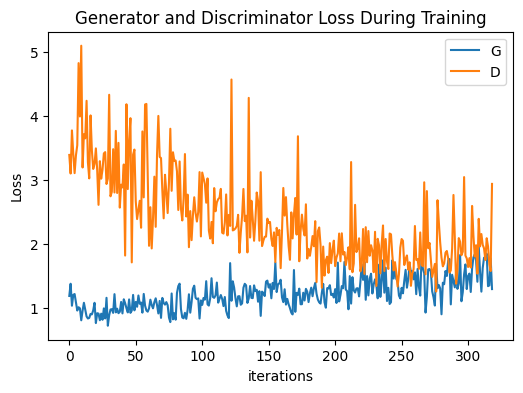

In [21]:
plt.figure(figsize=(6, 4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()